**KCNET Apprach Given In paper**

Loading Odor Dataset...
Dataset shape: (4983, 140)
    nonStereoSMILES                                        descriptors  \
0           CC(O)CN                                              fishy   
1     CCC(=O)C(=O)O             fatty;lactonic;sweet;caramellic;creamy   
2  O=C(O)CCc1ccccc1     rose;floral;fatty;sweet;musk;cinnamon;balsamic   
3     OCc1ccc(O)cc1  medicinal;phenolic;fruity;nutty;bitter;sweet;a...   
4    O=Cc1ccc(O)cc1  phenolic;woody;nutty;vanilla;hay;metallic;swee...   

   alcoholic  aldehydic  alliaceous  almond  amber  animal  anisic  apple  \
0          0          0           0       0      0       0       0      0   
1          0          0           0       0      0       0       0      0   
2          0          0           0       0      0       0       0      0   
3          0          0           0       1      0       0       0      0   
4          0          0           0       1      0       0       0      0   

   ...  tropical  vanilla  vegetable  vet

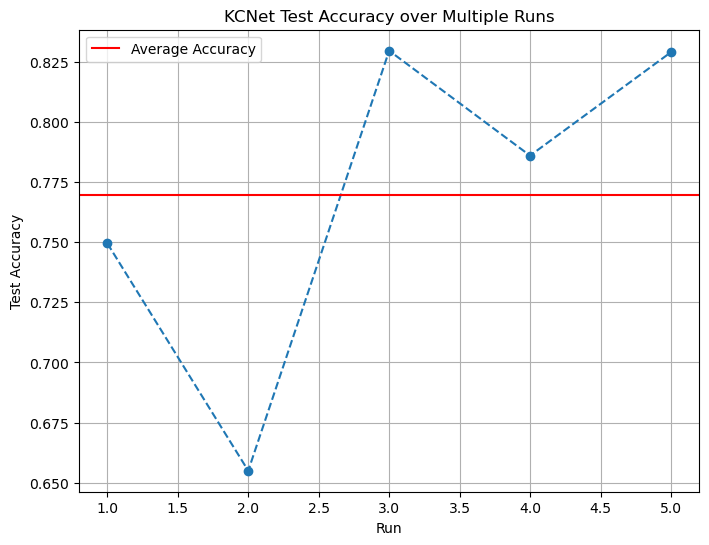

In [55]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import matplotlib.pyplot as plt

# 1. Load and Preprocess Odor Dataset
print("Loading Odor Dataset...")
data_path = "C:\\Users\\user\\Desktop\\Multi-Labelled_Smiles_Odors_dataset.csv"  # Path to your dataset

# Load the dataset
data = pd.read_csv(data_path)
print(f"Dataset shape: {data.shape}")
print(data.head())

# Extract features (only numeric columns and exclude non-numeric ones)
X = data.drop(columns=['nonStereoSMILES', 'descriptors']).select_dtypes(include=[np.number])

# Extract labels (odor descriptors column)
y_raw = data['descriptors']

# Multi-label binarization for odor classes
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw.astype(str).str.split(','))

print(f"Number of features: {X.shape[1]}")
print(f"Number of Odor Classes: {len(mlb.classes_)}")

# 2. Preprocess Data
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 3. KCNet Model Definition
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression

    def forward(self, x):
        """
        Forward pass for KCNet.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Global inhibition and ReLU
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        inhibited_activations = hidden_activations - 0.1 * mean_activation
        sparse_output = torch.relu(inhibited_activations)
        
        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")

# 4. Training and Evaluation Functions
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []
    for data, target in train_loader:
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(target)
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model for multi-label classification.
    """
    all_predictions = []
    all_labels = []
    for data, target in data_loader:
        output = model(data)
        predictions = (output > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
    accuracy = accuracy_score(np.array(all_labels).flatten(), np.array(all_predictions).flatten())
    return accuracy

# 5. Training and Evaluation Pipeline
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 6500             # Number of hidden neurons (Kenyon cells)
output_dim = y_train.shape[1]  # Number of odor classes
connections_per_hidden = 7     # Sparse connections per hidden neuron

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)

# Train and evaluate the model over multiple runs
n_runs = 5
results = []
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    train_kcnet(kcnet, train_loader, lambda_reg=0.1)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    results.append(test_accuracy)
    print(f"Test Accuracy Run {run + 1}: {test_accuracy * 100:.2f}%")

# Calculate average accuracy and standard deviation
average_accuracy = np.mean(results)
std_deviation = np.std(results)

print(f"Average Accuracy: {average_accuracy * 100:.2f}% ± {std_deviation * 100:.2f}%")

# Plot accuracy distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_runs + 1), results, marker='o', linestyle='--')
plt.axhline(average_accuracy, color='r', linestyle='-', label="Average Accuracy")
plt.title("KCNet Test Accuracy over Multiple Runs")
plt.xlabel("Run")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.savefig('accuracy_KCNET.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
plt.show()


Input Gain Inhibtion

Loading Odor Dataset...
Dataset shape: (4983, 140)
    nonStereoSMILES                                        descriptors  \
0           CC(O)CN                                              fishy   
1     CCC(=O)C(=O)O             fatty;lactonic;sweet;caramellic;creamy   
2  O=C(O)CCc1ccccc1     rose;floral;fatty;sweet;musk;cinnamon;balsamic   
3     OCc1ccc(O)cc1  medicinal;phenolic;fruity;nutty;bitter;sweet;a...   
4    O=Cc1ccc(O)cc1  phenolic;woody;nutty;vanilla;hay;metallic;swee...   

   alcoholic  aldehydic  alliaceous  almond  amber  animal  anisic  apple  \
0          0          0           0       0      0       0       0      0   
1          0          0           0       0      0       0       0      0   
2          0          0           0       0      0       0       0      0   
3          0          0           0       1      0       0       0      0   
4          0          0           0       1      0       0       0      0   

   ...  tropical  vanilla  vegetable  vet

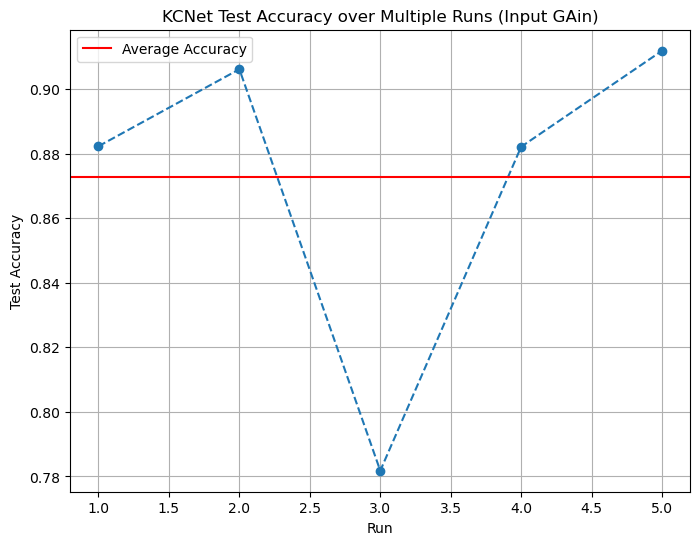

In [57]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import matplotlib.pyplot as plt

# 1. Load and Preprocess Odor Dataset
print("Loading Odor Dataset...")
data_path = "C:\\Users\\user\\Desktop\\Multi-Labelled_Smiles_Odors_dataset.csv"  # Path to your dataset

# Load the dataset
data = pd.read_csv(data_path)
print(f"Dataset shape: {data.shape}")
print(data.head())

# Extract features (only numeric columns and exclude non-numeric ones)
X = data.drop(columns=['nonStereoSMILES', 'descriptors']).select_dtypes(include=[np.number])

# Extract labels (odor descriptors column)
y_raw = data['descriptors']

# Multi-label binarization for odor classes
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw.astype(str).str.split(','))

print(f"Number of features: {X.shape[1]}")
print(f"Number of Odor Classes: {len(mlb.classes_)}")

# 2. Preprocess Data
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 3. Sparse Projection Matrix Generator
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

# 4. KCNet Model Definition with Localized Inhibition
class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression

    def forward(self, x):
        """
        Forward pass for KCNet with Localized Inhibition.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Localized inhibition (mean and std normalization)
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        std_activation = hidden_activations.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        localized_inhibition = (hidden_activations - 0.21*mean_activation) / std_activation

        # Apply ReLU for sparsity after localized inhibition
        sparse_output = torch.relu(localized_inhibition)

        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output

    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")

# 5. Training and Evaluation Functions
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []
    for data, target in train_loader:
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(target)
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model for multi-label classification.
    """
    all_predictions = []
    all_labels = []
    for data, target in data_loader:
        output = model(data)
        predictions = (output > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
    accuracy = accuracy_score(np.array(all_labels).flatten(), np.array(all_predictions).flatten())
    return accuracy

# 6. Training and Evaluation Pipeline
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 6500             # Number of hidden neurons (Kenyon cells)
output_dim = y_train.shape[1]  # Number of odor classes
connections_per_hidden = 7     # Sparse connections per hidden neuron

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)

# Train and evaluate the model over multiple runs
n_runs = 5
results = []
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    train_kcnet(kcnet, train_loader, lambda_reg=0.1)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    results.append(test_accuracy)
    print(f"Test Accuracy Run {run + 1}: {test_accuracy * 100:.2f}%")

# Calculate average accuracy and standard deviation
average_accuracy = np.mean(results)
std_deviation = np.std(results)

print(f"Average Accuracy: {average_accuracy * 100:.2f}% ± {std_deviation * 100:.2f}%")

# Plot accuracy distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_runs + 1), results, marker='o', linestyle='--')
plt.axhline(average_accuracy, color='r', linestyle='-', label="Average Accuracy")
plt.title("KCNet Test Accuracy over Multiple Runs (Input GAin)")
plt.xlabel("Run")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.savefig('accuracy_KCNET_localized_inhibition.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
plt.show()


Homeostatic Scaling Inhibtion

Dataset shape: (4983, 140)
    nonStereoSMILES                                        descriptors  \
0           CC(O)CN                                              fishy   
1     CCC(=O)C(=O)O             fatty;lactonic;sweet;caramellic;creamy   
2  O=C(O)CCc1ccccc1     rose;floral;fatty;sweet;musk;cinnamon;balsamic   
3     OCc1ccc(O)cc1  medicinal;phenolic;fruity;nutty;bitter;sweet;a...   
4    O=Cc1ccc(O)cc1  phenolic;woody;nutty;vanilla;hay;metallic;swee...   

   alcoholic  aldehydic  alliaceous  almond  amber  animal  anisic  apple  \
0          0          0           0       0      0       0       0      0   
1          0          0           0       0      0       0       0      0   
2          0          0           0       0      0       0       0      0   
3          0          0           0       1      0       0       0      0   
4          0          0           0       1      0       0       0      0   

   ...  tropical  vanilla  vegetable  vetiver  violet  warm  waxy

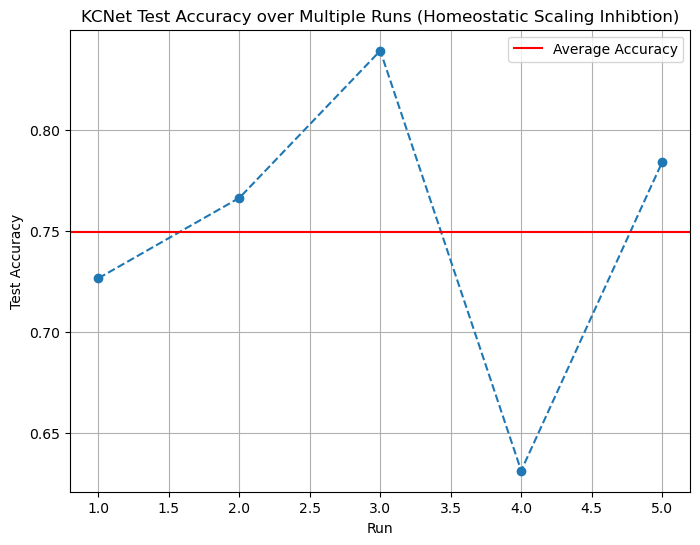

In [64]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
import matplotlib.pyplot as plt

# 1. Load and Preprocess Odor Dataset
data_path = "C:\\Users\\user\\Desktop\\Multi-Labelled_Smiles_Odors_dataset.csv"  # Path to your dataset

# Load the dataset
data = pd.read_csv(data_path)
print(f"Dataset shape: {data.shape}")
print(data.head())

# Extract features (only numeric columns and exclude non-numeric ones)
X = data.drop(columns=['nonStereoSMILES', 'descriptors']).select_dtypes(include=[np.number])

# Extract labels (odor descriptors column)
y_raw = data['descriptors']

# Multi-label binarization for odor classes
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(y_raw.astype(str).str.split(','))

print(f"Number of features: {X.shape[1]}")
print(f"Number of Odor Classes: {len(mlb.classes_)}")

# 2. Preprocess Data
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# 3. Sparse Projection Matrix Generator
def generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden):
    """
    Generates a sparse binary projection matrix.
    """
    projection = torch.zeros(hidden_dim, input_dim)
    for i in range(hidden_dim):
        selected_indices = torch.randperm(input_dim)[:connections_per_hidden]
        projection[i, selected_indices] = 1
    return projection

# 4. KCNet Model Definition with Localized Inhibition
class KCNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, connections_per_hidden):
        """
        Initializes the KCNet model.
        """
        super(KCNet, self).__init__()
        self.projection_matrix = generate_sparse_projection(input_dim, hidden_dim, connections_per_hidden)
        self.output_weights = None  # To be trained using ridge regression

    def forward(self, x):
        """
        Forward pass for KCNet with Localized Inhibition.
        """
        # Step 1: Random projection
        hidden_activations = torch.matmul(x, self.projection_matrix.T)
        
        # Step 2: Localized inhibition (mean-based scaling)
        mean_activation = hidden_activations.mean(dim=1, keepdim=True)
        std_activation = hidden_activations.std(dim=1, keepdim=True) + 1e-6  # Avoid division by zero
        alpha = 0.4  # Inhibition strength factor
        localized_inhibtion = alpha * (hidden_activations / mean_activation)
    
        # Apply ReLU for sparsity after localized inhibition
        sparse_output = torch.relu(localized_inhibtion)
    
        # Step 3: Linear output layer
        output = sparse_output @ self.output_weights
        return output


    def train_output_layer(self, hidden_layer_outputs, targets, lambda_reg=0.01):
        """
        Trains the output layer weights using ridge regression.
        """
        H_T = hidden_layer_outputs.T
        regularization = lambda_reg * torch.eye(H_T.shape[0])

        try:
            ridge_matrix = torch.inverse(H_T @ hidden_layer_outputs + regularization)
            self.output_weights = ridge_matrix @ H_T @ targets
        except Exception as e:
            print(f"Error during matrix inversion: {e}")

# 5. Training and Evaluation Functions
def train_kcnet(model, train_loader, lambda_reg=0.1):
    """
    Trains the KCNet's output weights using ridge regression.
    """
    all_hidden_outputs = []
    all_targets = []
    for data, target in train_loader:
        hidden_activations = torch.relu(data @ model.projection_matrix.T)
        all_hidden_outputs.append(hidden_activations)
        all_targets.append(target)
    hidden_outputs = torch.cat(all_hidden_outputs, dim=0)
    targets = torch.cat(all_targets, dim=0)
    model.train_output_layer(hidden_outputs, targets, lambda_reg)

def evaluate_kcnet(model, data_loader):
    """
    Evaluates the KCNet model for multi-label classification.
    """
    all_predictions = []
    all_labels = []
    for data, target in data_loader:
        output = model(data)
        predictions = (output > 0.5).int()
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(target.cpu().numpy())
    accuracy = accuracy_score(np.array(all_labels).flatten(), np.array(all_predictions).flatten())
    return accuracy

# 6. Training and Evaluation Pipeline
input_dim = X_train.shape[1]  # Number of input features
hidden_dim = 6500             # Number of hidden neurons (Kenyon cells)
output_dim = y_train.shape[1]  # Number of odor classes
connections_per_hidden = 7     # Sparse connections per hidden neuron

# Initialize KCNet
kcnet = KCNet(input_dim, hidden_dim, output_dim, connections_per_hidden)

# Train and evaluate the model over multiple runs
n_runs = 5
results = []
for run in range(n_runs):
    print(f"Run {run + 1}/{n_runs}")
    train_kcnet(kcnet, train_loader, lambda_reg=0.1)
    test_accuracy = evaluate_kcnet(kcnet, test_loader)
    results.append(test_accuracy)
    print(f"Test Accuracy Run {run + 1}: {test_accuracy * 100:.2f}%")

# Calculate average accuracy and standard deviation
average_accuracy = np.mean(results)
std_deviation = np.std(results)

print(f"Average Accuracy: {average_accuracy * 100:.2f}% ± {std_deviation * 100:.2f}%")

# Plot accuracy distribution
plt.figure(figsize=(8, 6))
plt.plot(range(1, n_runs + 1), results, marker='o', linestyle='--')
plt.axhline(average_accuracy, color='r', linestyle='-', label="Average Accuracy")
plt.title("KCNet Test Accuracy over Multiple Runs (Homeostatic Scaling Inhibtion)")
plt.xlabel("Run")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid()
plt.savefig('accuracy_KCNET_Homeostatic.png', dpi=300, bbox_inches='tight')  # Save high-quality plot
plt.show()
